# <font color= 'red'> PA005 - High Value Customer Identification

## Imput

## Business Challenge

- Select the most valuable customers to build the loyalty program called 'Insiders'.
- Data set with more product sales during the year. ( Nov/2015 - Dec/2017 )

## Output

1. Indication of people to be part of the program.
2. A report with the answers to following question:
    - Who are the eligible people for the Insiders Program?
    - How many people will be in the group?
    - Which are the main characteristics of these customers?
    - What is the percentage revenue contribution coming from Insiders?
    - What is the revenue expectation for the next few months?
    - Which are the conditions for the people to be eligible from the program?
    - Which are the conditions for the people to be removed from the program?
    - What is the guarantee that the Insiders Problem is better than the rest of the base?
    - What are the action the marketing time can do to enhance the revenue?

## Task - Process

1. Who are the eligible people for the Insiders Program?
    - What is be eligible? What are high value customers?
    - Income:
        - High averange ticket;
        - High LTV;
        - Low recently;
        - High basket size;
        - Low Churn probability;
        - High LTV probability;
        - High buy propensity;
        
        
   - Cost:  
        - Low return rate;
    
    
   - Buyer Experience:
        - High averange rate;
2. How many people will be in the group?
    - Total customers number;
    - % Insider Group;
    
    
3. Which are the main characteristics of these customers?
    - Customer characteristics:
        - Age;
        - Location;
        
    -  Consumption characteristics:
        - Clustering Attributtes;
        
4. What is the percentage revenue contribution coming from Insiders?
    - Total revenue of the year;
    - Renenue of the Insiders group;
        
        
5. What is the revenue expectation for the next few months? 
    - LTV of the Insider Group;
    - Cohort Analysis;
    
    
6. Which are the conditions for the people to be eligible from the program?
    - Define the periodicity ( 1 month, 3 months);
    - The people needs to be similary or seemed to other people in the group?
    
    
7. Which are the conditions for the people to be removed from the program?
    - Define the periodicity ( 1 month, 3 months);
    - The people needs to be similary or seemed to other people in the group?
    
    
8. What is the guarantee that the Insiders Problem is better than the rest of the base?
    - A/B Test;
    - Bayesian A/B Test;
    - Hyphotesis Test;


9. What are the action the marketing time can do to enhance the revenue?
    - Discount;
    - Purchase Preferences
    - Front
    - Company Visit;

# 0.1 Import

In [3]:
import  re
import  inflection
import  pandas      as pd
import  seaborn     as sns
import  numpy       as np
import  umap.umap_  as umap

import  matplotlib.pyplot  as plt


from  sklearn  import  cluster       as c
from  sklearn  import  metrics       as m
from  sklearn  import  mixture       as mx
from  plotly   import  express       as px
from  sklearn  import  ensemble      as en
from  sklearn  import  manifold      as mn
from  sklearn  import  decomposition as dd
from  sklearn  import  preprocessing as pp

from  scipy.cluster import hierarchy as hc

from IPython.display          import Image
from  sklearn.neighbors       import NearestNeighbors



# <font color= 'red'> 1.0 Data Description

## 1.1 Loading Dataset

In [4]:
df_raw = pd.read_csv( '/Users/adriele/Documents/repos/pa005/data/ecommerce.csv', encoding='iso-8859-1' )

# dropping extra column
df_raw = df_raw.drop( columns= ['Unnamed: 8'], axis=1 )

## 1.2 Rename Columns

In [5]:
df1 = df_raw.copy()

# Renaming Cols
cols_old = [ 'InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']

snakecase = lambda x: inflection.underscore (x)

cols_new = list (map (snakecase , cols_old))

# rename
df1.columns = cols_new

## 1.3 Data Dimensions

In [6]:
print( 'Number of Cols {}'.format( df1.shape[1] ) )
print( 'Number of Rows {}'.format( df1.shape[0] ) )

Number of Cols 8
Number of Rows 541909


## 1.4 Check NA

In [7]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Replace NA

In [8]:
df_missing = df1.loc[ df1[ 'customer_id' ].isna(), :]
df_not_missing = df1.loc[ ~df1['customer_id' ].isna(), :]


# Create reference
df_backup = pd.DataFrame( df_missing['invoice_no'].drop_duplicates() )
df_backup[ 'customer_id' ] = np.arange( 19000, 19000+len( df_backup ), 1)

# Merge original with reference df
df1 = pd.merge( df1, df_backup, on='invoice_no', how='left' )

# Coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first( df1['customer_id_y'])

# drop extra column
df1 = df1.drop( columns=['customer_id_x', 'customer_id_y'], axis=1 )


# removing Na
df1 = df1.dropna( subset=[ 'description', 'customer_id'] )
print( 'Removed Data: {:.2f}%'.format( 1-( df1.shape[0] / df_raw.shape[0] ) ) )

Removed Data: 0.00%


In [9]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
country         0
customer_id     0
dtype: int64

## 1.6 Data Types

In [10]:
# Invoice Date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y')

# Customer Id
df1['customer_id'] = df1['customer_id'].astype( int)

In [11]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## 1.7 Descriptive Startistcs

In [12]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=[ 'int64', 'float64', 'datetime64[ns]'] )

### 1.7.1 Numerical Attributes

- Negative quantity can be returns;
- Unitary price equal 0 can be promotions;

In [13]:
# Central Tendency - mean, Median
ct1 = pd.DataFrame (num_attributes.apply (np.mean) ).T
ct2 = pd.DataFrame (num_attributes.apply (np.median) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame (num_attributes.apply (np.std) ).T
d2 = pd.DataFrame (num_attributes.apply (min)).T
d3 = pd.DataFrame (num_attributes.apply (max)).T
d4 = pd.DataFrame (num_attributes.apply (lambda x: x.max () -x.min ()) ).T
d5 = pd.DataFrame (num_attributes.apply (lambda x: x.skew () ) ).T
d6 = pd.DataFrame (num_attributes.apply (lambda x: x.kurtosis ()) ).T

# Concatane
m1 =pd.concat ([ d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m1.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m1

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.603129,3.00,218.007397,-0.281253,120252.449063
1,unit_price,-11062.06,38970.0,50032.06,4.623519,2.08,96.889538,186.257919,58848.017575
2,customer_id,12346.00,22709.0,10363.00,16678.153600,16241.00,2907.570262,0.493600,-0.792496


### 1.7.2 Attributes Category

#### Invoice No

In [14]:
# Invoice No
df_letter_invoices = df1.loc[df1[ 'invoice_no' ].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), :]

print( 'Total number of invoices: {}'.format( len( df_letter_invoices) ) )
print( 'Total number of negative invoices: {}'.format( len( df_letter_invoices[ df_letter_invoices[ 'quantity' ] < 0] ) ) )

Total number of invoices: 9291
Total number of negative invoices: 9288


#### Stock Code

In [15]:
# Stock code - check characters
df1.loc[df1[ 'stock_code' ].apply( lambda x: bool( re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code'].unique()



array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

#### Country

In [16]:
df1['country'].value_counts( normalize=True ).head()

United Kingdom    0.914089
Germany           0.017569
France            0.015833
EIRE              0.015165
Spain             0.004687
Name: country, dtype: float64

In [17]:
c = df1[['customer_id', 'country']].drop_duplicates().groupby( 'country' ).count(
).reset_index().sort_values( 'customer_id', ascending=False )

c.head()

,country,customer_id
36,United Kingdom,6133
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31


# <font color= 'red'> 2.0 Feature Filtering

In [18]:
df2 = df1.copy()

# Numerical Attributes
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# Categorical Attributes
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'] ) ]

#Descrption
df2 = df2.drop( columns='description', axis=1 )

# Description
df2= df2[~df2['country'].isin( ['European Comunity', 'Unspecified'] ) ]

# Bad Users
df2 = df2[~df2['customer_id'].isin( [16446] )]
# Quantity
df2_returns = df2.loc[ df1[ 'quantity' ] <0, : ]
df2_purchases = df2.loc[ df1[ 'quantity' ] >=0, : ]

# <font color= 'red'> 3.0 Feature Engineering

In [19]:
df3 = df2.copy()

## 3.1 Feature Creation

In [20]:
# Data reference
df_ref = df3.drop(['invoice_no', 'stock_code','quantity', 
          'invoice_date', 'unit_price', 'country'], axis=1).drop_duplicates( ignore_index=True )

### 3.1.1 Gross Revenue

In [21]:
# Gross Revenue = quantity * price
df2_purchases.loc[:,'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']

# Monetary
df_monetary = df2_purchases.loc[:, [ 'customer_id', 'gross_revenue' ]].groupby( 'customer_id' ).sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left' )
df_ref.isna().sum()

/var/folders/pc/6sglrsq96ws5kp74fjj4j02h0000gn/T/ipykernel_24822/1692327438.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_purchases.loc[:,'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']


customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2 Recency - Last Day Purchase

In [22]:
# Recency - Last day purchase

df_recency = df2_purchases.loc[:, ['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = ( df2['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### 3.1.5 Quantity of Products Purchased

In [23]:
df_freq = (df2_purchases.loc[:, ['customer_id', 'stock_code']].drop_duplicates().groupby( 'customer_id').count
           ().reset_index().rename( columns={ 'stock_code': 'qtde_products'} ) )

df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_products    91
dtype: int64

### 3.1.8 Frequency Purchase

In [24]:
df_aux = ( df2_purchases[[ 'customer_id', 'invoice_date', 'invoice_no']].drop_duplicates()
                                                              .groupby( 'customer_id' )
                                                              .agg( max_ = ( 'invoice_date', 'max' ),
                                                                    min_ = ( 'invoice_date', 'min' ),
                                                                    days_ = ( 'invoice_date', lambda x: ( x.max()  - x.min() ).days ),
                                                                    buy_ = ( 'invoice_no', 'count') ) ).reset_index()

# Frequency
df_aux['frequency'] = df_aux[[ 'buy_', 'days_' ]].apply( lambda x: x[ 'buy_' ] / x['days_'] if x['days_'] != 0 else 0, axis=1 )


# Merge
df_ref = pd.merge( df_ref, df_aux[[ 'customer_id', 'frequency' ]], on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_products    91
frequency        91
dtype: int64

### 3.1.9 Number of Returns

In [25]:
df_returns = df2_returns[[ 'customer_id', 'quantity' ]].groupby( 'customer_id' ).sum(
                     ).reset_index().rename( columns={ 'quantity': 'qtde_returns' } )

df_returns[ 'qtde_returns' ] = df_returns[ 'qtde_returns' ] * -1

df_ref = pd.merge( df_ref, df_returns, how='left', on='customer_id' )
df_ref.loc[ df_ref[ 'qtde_returns' ].isna(), 'qtde_returns' ] = 0


df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_products    91
frequency        91
qtde_returns      0
dtype: int64

In [26]:
df_ref.shape

(5787, 6)

# <font color= 'red'> 4.0 Exploratory Data Analysis

In [27]:
df4 = df_ref.dropna()
# df4.isna().sum()

In [28]:
df4.shape

(5696, 6)

## 4.3 Space Study

In [29]:
# Select Dataset
cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'qtde_products', 'frequency', 'qtde_returns' ]
df43 = df4[ cols_selected ].drop( columns='customer_id', axis=1) 


mm = pp.MinMaxScaler()

df43[ 'gross_revenue' ]    = mm.fit_transform( df43[[ 'gross_revenue' ]] )
df43[ 'recency_days' ]     = mm.fit_transform( df43[[ 'recency_days' ]] )
df43[ 'qtde_products' ]    = mm.fit_transform( df43[[ 'qtde_products' ]] )
df43[ 'frequency' ]        = mm.fit_transform( df43[[ 'frequency' ]] )
df43[ 'qtde_returns' ]     = mm.fit_transform( df43[[ 'qtde_returns' ]] )


x = df43.copy()


In [30]:
df43.shape

(5696, 5)

### 4.3.1 PCA

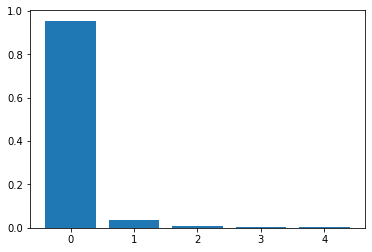

In [31]:
pca = dd.PCA( n_components =  x.shape[1] )

principal_components = pca.fit_transform( x )

# Plot Explaneid Variable
features = range( pca.n_components_ )

plt.bar( features, pca.explained_variance_ratio_)

# PCA Conponent
df_pca = pd.DataFrame( principal_components )

<AxesSubplot:xlabel='0', ylabel='1'>

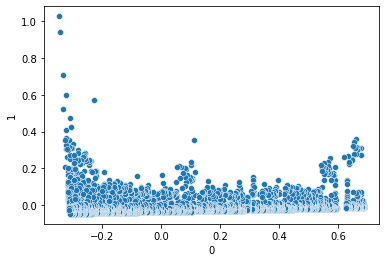

In [32]:
sns.scatterplot( x=0, y=1, data=df_pca )

### 4.3.2 UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

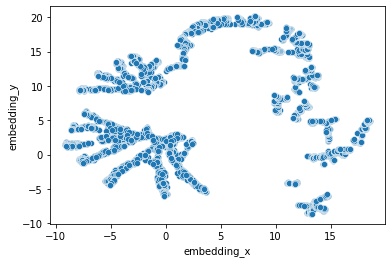

In [33]:
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( x )

# Embedding
df_umap = pd.DataFrame()
df_umap['embedding_x'] = embedding[:, 0]
df_umap['embedding_y'] = embedding[:, 1]


# Plot UMAP
sns.scatterplot( x='embedding_x',
                 y='embedding_y',
                 data = df_umap )

### 4.3.3 T-SNE

/Users/adriele/opt/anaconda3/envs/env_pa005/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/adriele/opt/anaconda3/envs/env_pa005/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

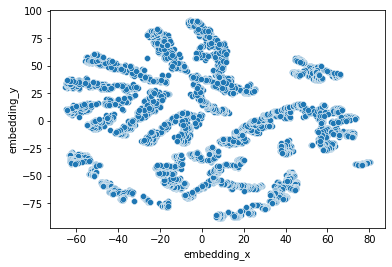

In [34]:
reducer = mn.TSNE( n_components=2, random_state=42, n_jobs =1)

embedding = reducer.fit_transform( x )

# Embedding
df_tsne = pd.DataFrame()
df_tsne['embedding_x'] = embedding[:, 0]
df_tsne['embedding_y'] = embedding[:, 1]


# Plot UMAP
sns.scatterplot( x='embedding_x',
                 y='embedding_y',
                 data = df_tsne )

### 4.3.4 Tree Based Embeding

/Users/adriele/opt/anaconda3/envs/env_pa005/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

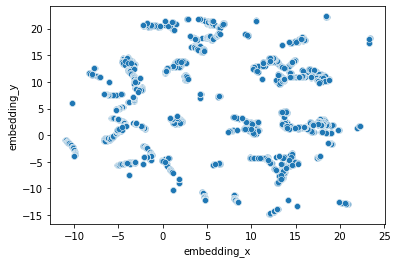

In [35]:
x = df43.drop( columns=['gross_revenue'], axis=1)
y = df43['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor( n_estimators=100, random_state=42 )

# Model training
rf_model.fit( x, y )



# dataframe Leaf
df_leaf= pd.DataFrame( rf_model.apply( x ) )



reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( df_leaf )

# Embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]


# Plot UMAP
sns.scatterplot( x='embedding_x',
                 y='embedding_y',
                 data = df_tree )


# <font color= 'red'> 5.0 Data Preparation

In [36]:
# Tree Based Embedding
#df5 = df_tree.copy()


# umap Embedding
#df5 = df_umap.copy()

# TSNE Embedging
df5 = df_tsne.copy()


# <font color= 'red'> 7.0 Fine Tunning Hyperparameter

In [37]:
x= df5.copy()
x.head()

,embedding_x,embedding_y
0,50.817120,40.706398
1,-9.595375,1.638194
2,6.621437,56.698040
3,62.638588,9.791942
4,43.675007,-48.542057


## 7.1 K-Means

In [38]:
from  sklearn  import  cluster  as c

kmeans_list = []
for k in clusters:
    # Model definition
    kmeans_model = c.KMeans( n_clusters=k, n_init=100, random_state=42 )

    # Model training
    kmeans_model.fit( x )

    # Model  predict
    labels = kmeans_model.predict( x )

    # Model performance
    sil = m.silhouette_score( x, labels, metric='euclidean')
    kmeans_list.append( sil )
    
    
    
plt.plot( clusters, kmeans_list, linestyle='--', marker='o', color='b')  
plt.xlabel( 'k');
plt.ylabel( 'Silhouette Score' );
plt.title( 'Silhouette Score X K');

NameError: name 'clusters' is not defined

## 7.2 GMM

In [ ]:
gmm_list = []
for k in clusters:
    # Model definition
    gmm_model = mx.GaussianMixture( n_components=k, n_init=100, random_state=42  )

    # Model training
    gmm_model.fit( x )

    # Model  predict
    labels = gmm_model.predict( x )

    # Model performance
    sil = m.silhouette_score( x, labels, metric='euclidean')
    gmm_list.append( sil )
    
    
    
plt.plot( clusters, gmm_list, linestyle='--', marker='o', color='b')  
plt.xlabel( 'k');
plt.ylabel( 'Silhouette Score' );
plt.title( 'Sil x K');

## 7.3 Hierarchical Clustering

In [ ]:
hc_model = hc.linkage( x, 'ward')

### 7.3.1. HClustering Silhouette Score

In [ ]:
hc_list = []
for k in clusters:
    # Model definition
    hc_model =hc.linkage( x, 'ward' )

    # Model  predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # Model performance
    sil = m.silhouette_score( x, labels, metric='euclidean')
    hc_list.append( sil )
    
    
    
plt.plot( clusters, hc_list, linestyle='--', marker='o', color='b')  
plt.xlabel( 'k');
plt.ylabel( 'Silhouette Score' );
plt.title( 'Sil x K');

## 7.5 Results 

In [ ]:
# # Results - Tree Based embedding

# df_results = pd.DataFrame({'KMeans': kmeans_list,
#                            'GMM' :gmm_list,
#                            'HC' : hc_list }
                         
#                          ).T

# df_results.columns = clusters
# df_results.style.highlight_max( color='lightgreen', axis=1)



In [ ]:
# # Results - UMAP embedding
# df_results = pd.DataFrame({'KMeans': kmeans_list,
#                            'GMM' :gmm_list,
#                            'HC' : hc_list }
                         
#                          ).T

# df_results.columns = clusters
# df_results.style.highlight_max( color='lightgreen', axis=1)



In [ ]:
# Results -  TSNE embedding
df_results = pd.DataFrame({'KMeans': kmeans_list,
                           'GMM' :gmm_list,
                           'HC' : hc_list }
                         
                         ).T

df_results.columns = clusters
df_results.style.highlight_max( color='lightgreen', axis=1)



# <font color= 'red'> 8.0 Model Training

## 8.1 Final Model

In [ ]:
#Model definition
k = 8

# Model definition
gmm_model = mx.GaussianMixture( n_components=k, n_init=300, random_state=42 )

# Model training
gmm_model.fit( x )

# Model  predict
labels = gmm_model.predict( x )




## 8.2 Cluster Validation

In [ ]:
# WSS (Within cluster sum of square)
#print( 'WSS value: {}'.format( kmeans.inertia_ ) )

# SS ( Silhouette score )
print( 'SS value: {}'.format( m.silhouette_score( x, labels, metric='euclidean' ) ) )

# <font color= 'red'> 9.0 Cluster Analysis

In [ ]:
df9 = x.copy()
df9['cluster'] = labels

#sns.scatterplot( x= 'embedding_x', y='embedding_y', hue='cluster', data=df9, palette='deep')

In [ ]:
#changing Dtypes
df92['recency_days'] = df92['recency_days'].astype( int )
df92['qtde_products'] = df92['qtde_products'].astype( int )
df92['qtde_returns'] = df92['qtde_returns'].astype( int )

# Number of customer
df_cluster = df92[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100*( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg Gross Revenue
df_avg_gross_revenue = df92[['gross_revenue', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster' )

# Agv recency days
df_avg_recency_days = df92[['recency_days', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, how='inner', on='cluster' )

# Avg invoice no
df_avg_invoice_no = df92[['qtde_products', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_invoice_no, how='inner', on='cluster' )

# Frequency
df_frequency = df92[['frequency', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_frequency, how='inner', on='cluster' )

# Returns
df_returns = df92[['qtde_returns', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_returns, how='inner', on='cluster' )



In [ ]:
df_cluster.sort_values( 'gross_revenue', ascending=False )

## Cluster 01:  ( Insider Candidate )

  - Number of Customer = 4,335 ( 99% of customer )
  - Averange Recency   = 92 days;
  - Averange Purchase  = 5 purchase
  - Averang  Revenue   =  $ 1.372,57 dolars
  
# Cluster 02:

  - Number of Customer = 31 ( 71% of customer )
  - Averange Recency   = 13 days;
  - Averange Purchase  = 53 purchase
  - Averang  Revenue   =  $ 40,543,51 dolars  
  
# Cluster 03:

  - Number of Customer = 4 ( 14% of customer )
  - Averange Recency   = 7 days;
  - Averange Purchase  = 89 purchase
  - Averang  Revenue   =  $ 182,181.98 dolars    

# <font color= 'red'> 10.0 Deploy to production

In [ ]:
df10 = df92.copy()
df10.head()

## 11.1 Insert to Sqlite

In [ ]:
import sqlite3
from sqlalchemy import create_engine

In [ ]:
# # CREATE TABLE
# query_create_table_insiders = """
#     CREATE TABLE insiders(
#         customer_id    ITERGER,
#         gross_revenue  REAL,
#         recency_days   INTERGER,
#         qtde_products  INTERGER,
#         frequency      REAL,
#         qtde_returns   INTERGER,
#         cluster       INTERGER
        
#     )
# """

# conn = sqlite3.connect( 'insiders_db.sqlite' )
# conn.execute( query_create_table_insiders )
# conn.commit()
# conn.close()

# insert data
conn = create_engine( 'sqlite:///insiders_db.sqlite' )
#df92.to_sql('insiders', con=conn, if_exists='append', index=False )


# select data

In [ ]:
# Consulting data base
query = """

    SELECT * FROM insiders
    
"""

df =pd.read_sql_query( query, conn)

In [ ]:
df.head()